## Forward Inference

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
import itertools
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf

In [12]:
df = pd.read_csv('cleaned_data.csv')

In [13]:
X = df[['duration',
       'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'profit']]

In [14]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Save the training and testing data as CSV files
train_data.to_csv('train_X.csv', index=False)
test_data.to_csv('test_X.csv', index=False)

In [15]:
train_X = pd.read_csv('train_X.csv')
test_X = pd.read_csv('test_X.csv')


In [16]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('profit~' + '+'.join(predictor_subset),data = train_X).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [17]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [18]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [19]:
models_best = forward_selection()

Processed  12 models on 1 predictors in 0.14535164833068848 seconds.
Processed  11 models on 2 predictors in 0.11348104476928711 seconds.
Processed  10 models on 3 predictors in 0.1551651954650879 seconds.
Processed  9 models on 4 predictors in 0.13816165924072266 seconds.
Processed  8 models on 5 predictors in 0.12872576713562012 seconds.
Processed  7 models on 6 predictors in 0.1617295742034912 seconds.
Processed  6 models on 7 predictors in 0.12111401557922363 seconds.
Processed  5 models on 8 predictors in 0.1175377368927002 seconds.
Processed  4 models on 9 predictors in 0.12769222259521484 seconds.
Processed  3 models on 10 predictors in 0.16066241264343262 seconds.
Processed  2 models on 11 predictors in 0.10864377021789551 seconds.
Processed  1 models on 12 predictors in 0.04805421829223633 seconds.
Total elapsed time: 1.6236708164215088 seconds.


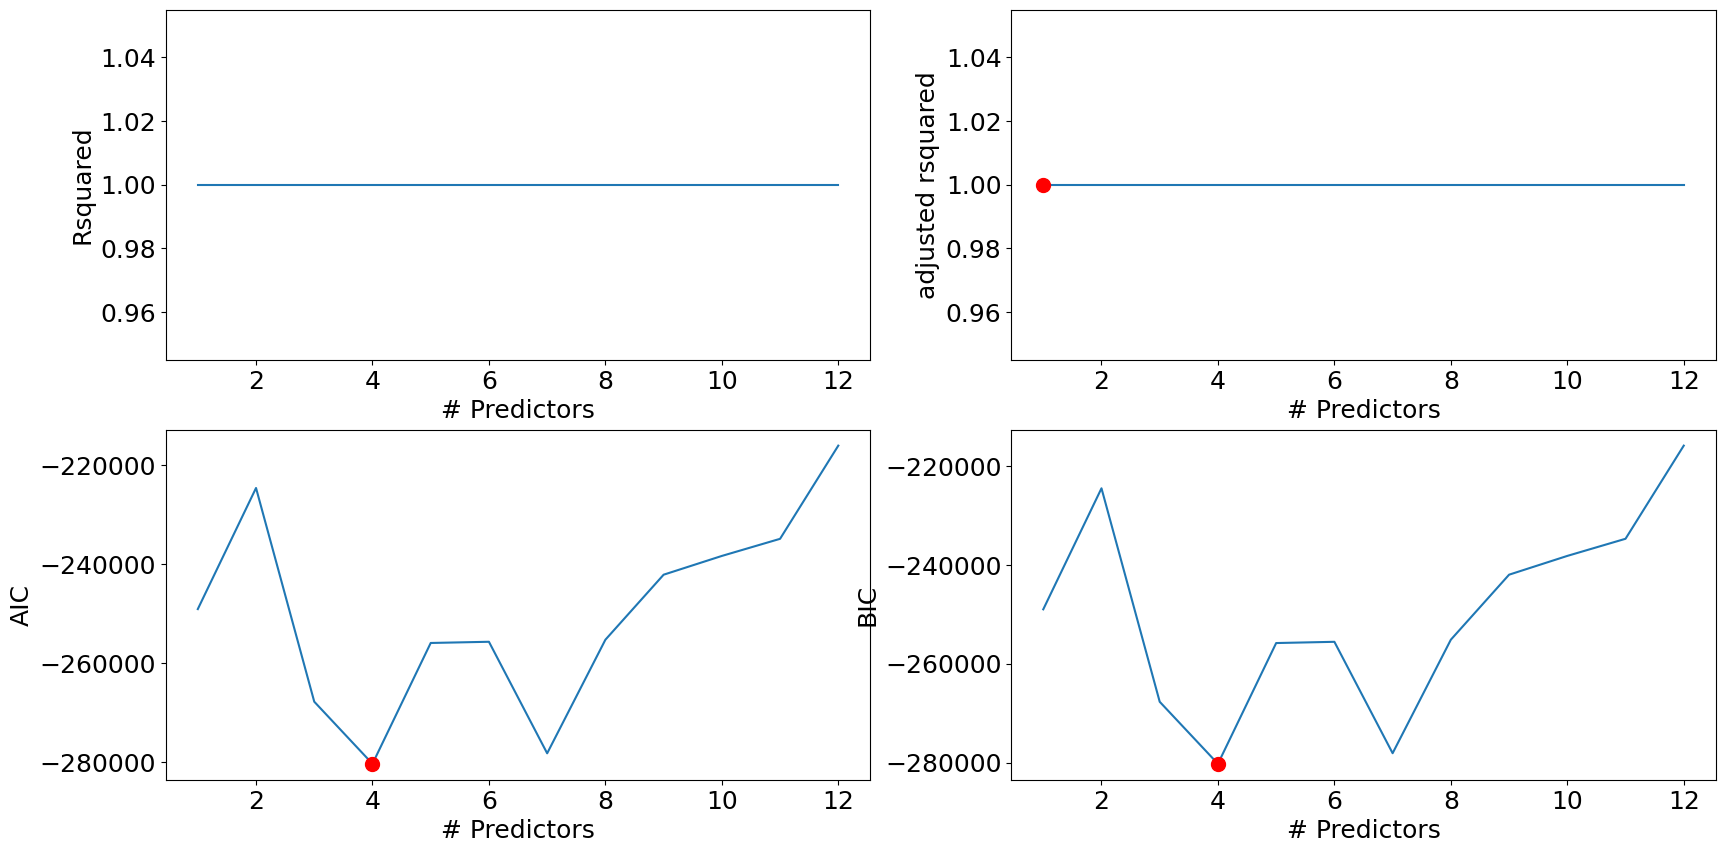

In [20]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

The model with 4 predictors is the best model, according to AIC and BIC.

In [21]:
best_fwd_reg_model = models_best.loc[4,'model']
models_best.loc[4,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.499e+34
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:11:59   Log-Likelihood:             1.4016e+05
No. Observations:                8989   AIC:                        -2.803e+05
Df Residuals:                    8984   BIC:                        -2.803e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.261e-08   2.14e-09      5.883      0.000    8.41e-09    1.68e-08
profit                      1.0000   1.72e-18   5.82e+17      0.000       1.000       1.000
duration                -4.805e-11   1.93e-11     -2.494      0.013   -8.58e-11   -1.03e-11
director_facebook_likes -3.199e-12   1.44e-13    -22.270      0.000   -3.48e-12   -2.92e-12
actor_3_facebook_likes   7.093e-13   2.21e-13      3.214      0.001    2.77e-13    1.14e-12
==============================================================================
Omnibus:                    24834.899   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        957481281.263
Skew:                         -35.048   Prob(JB):                         0.00
Kurtosis:                    1600.340   Cond. No.                     1.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_profit = np.exp(best_fwd_reg_model.predict(test_X))
np.sqrt(((pred_profit - test_X.profit)**2).mean())

c:\Users\Yasmeen\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


inf

Backward Stepwise Selection

In [23]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [24]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [25]:
models_best = backward_selection()

Processed  12 models on 11 predictors in 0.38013601303100586 seconds.
Processed  11 models on 10 predictors in 0.3227386474609375 seconds.
Processed  10 models on 9 predictors in 0.2570617198944092 seconds.
Processed  9 models on 8 predictors in 0.22258377075195312 seconds.
Processed  8 models on 7 predictors in 0.16084074974060059 seconds.
Processed  7 models on 6 predictors in 0.13624835014343262 seconds.
Processed  6 models on 5 predictors in 0.09669685363769531 seconds.
Processed  5 models on 4 predictors in 0.07271480560302734 seconds.
Processed  4 models on 3 predictors in 0.04876875877380371 seconds.
Processed  3 models on 2 predictors in 0.032163381576538086 seconds.
Processed  2 models on 1 predictors in 0.016022205352783203 seconds.
Total elapsed time: 1.8478121757507324 seconds.


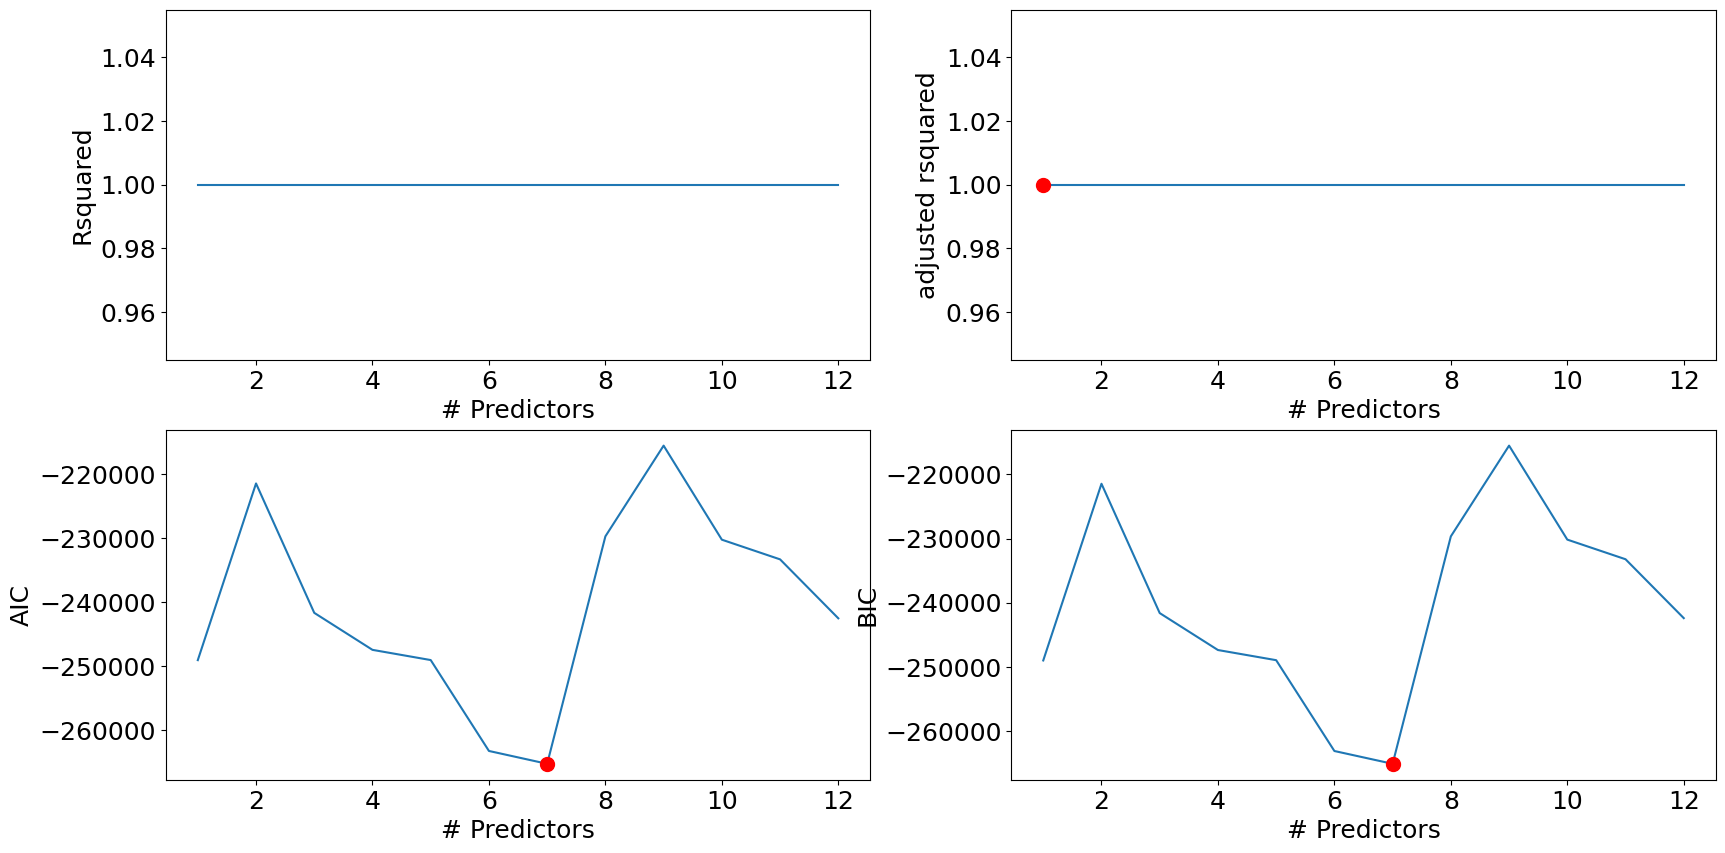

In [26]:
best_sub_plots()

In [27]:
best_bwd_reg_model = models_best['model'][7]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.052e+33
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:12:03   Log-Likelihood:             1.3261e+05
No. Observations:                8989   AIC:                        -2.652e+05
Df Residuals:                    8981   BIC:                        -2.651e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.492e-07   4.99e-09     69.945      0.000    3.39e-07    3.59e-07
duration                  -3.153e-09   4.49e-11    -70.275      0.000   -3.24e-09   -3.06e-09
director_facebook_likes   -5.882e-13   3.34e-13     -1.759      0.079   -1.24e-12    6.71e-14
actor_3_facebook_likes     5.108e-12   9.22e-13      5.538      0.000     3.3e-12    6.92e-12
actor_1_facebook_likes     2.042e-12   3.24e-13      6.296      0.000    1.41e-12    2.68e-12
cast_total_facebook_likes -3.558e-12   2.87e-13    -12.398      0.000   -4.12e-12      -3e-12
facenumber_in_poster       1.807e-10   5.26e-10      0.343      0.731   -8.51e-10    1.21e-09
profit                        1.0000   3.98e-18   2.51e+17      0.000       1.000       1.000
==============================================================================
Omnibus:                     9106.307   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1618813.363
Skew:                           4.587   Prob(JB):                         0.00
Kurtosis:                      68.100   Cond. No.                     1.26e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#Finding the RMSE of the model selected using the backward selection procedure, where the predictors
#include 2-factor interactions
pred_profit = np.exp(best_bwd_reg_model.predict(test_X))
np.sqrt(((pred_profit - test_X.profit)**2).mean())

c:\Users\Yasmeen\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


inf

The RMSE for the test set for both backward and forward selection models is much higher than that of the training set, so it is likely that we've badly over fit the data, i.e. we've created a model that tests well in sample, but has little predictive value when tested out of sample. This does not seem to be a good method for building a model.